# 손글씨 데이터 정보 + OCR 모델 결과물 합치기

## 라이브러리

In [1]:
import pandas as pd
import numpy as np
import os
import json
import pprint

import cv2
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

import paddleocr
from paddleocr import PaddleOCR, draw_ocr
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## 데이터 목록이 제대로 있는지 확인하는 코드

In [2]:
# JSON 파일 목록 정리
basic_path = 'data/HW_OCR/4.Validation/'
backgrounds = ['P.Paper/', 'T.Tablet/']
contents = ['R.Free/', 'O.Form/']
json_files_list = []
png_files_list = []

for background in backgrounds:
    for content in contents:
        tmp = []
        path = basic_path + background + content
        tmp = list(map(lambda x: path + str(x), filter(lambda x: x.endswith('.json'), os.listdir(path))))
        json_files_list.append(tmp)
        print('{}.json: {}개'.format(path, len(tmp)))
        
        tmp = list(map(lambda x: path + str(x), filter(lambda x: x.endswith('.png'), os.listdir(path))))
        png_files_list.append(tmp)
        print('{}.png: {}개'.format(path, len(tmp)))
        print()

data/HW_OCR/4.Validation/P.Paper/R.Free/.json: 35535개
data/HW_OCR/4.Validation/P.Paper/R.Free/.png: 35535개

data/HW_OCR/4.Validation/P.Paper/O.Form/.json: 43170개
data/HW_OCR/4.Validation/P.Paper/O.Form/.png: 43170개

data/HW_OCR/4.Validation/T.Tablet/R.Free/.json: 4789개
data/HW_OCR/4.Validation/T.Tablet/R.Free/.png: 4789개

data/HW_OCR/4.Validation/T.Tablet/O.Form/.json: 12525개
data/HW_OCR/4.Validation/T.Tablet/O.Form/.png: 12525개



In [3]:
cnt_P_AIHUB = 87205
cnt_T_AIHUB = 19314
cnt_AIHUB = cnt_P_AIHUB + cnt_T_AIHUB

P1 = len(json_files_list[0]) + len(json_files_list[1])
T1 = len(json_files_list[2]) + len(json_files_list[3])
print('갖고 있는 json 데이터 목록')
print('Paper: {}, Table: {}, total: {}'.format(P1, T1, P1+T1))
print('데이터 사이트와 내가 갖고 있는 데이터 목록 갯수와의 차이')
print('Paper: {}, Table: {}, total: {}'.format(cnt_P_AIHUB - P1, cnt_T_AIHUB - T1, cnt_AIHUB - (P1+T1)))

print()

P2 = len(png_files_list[0]) + len(png_files_list[1])
T2 = len(png_files_list[2]) + len(png_files_list[3])
print('갖고 있는 png 데이터 목록')
print('Paper: {}, Table: {}, total: {}'.format(P2, T2, P2+T2))
print('데이터 사이트와 내가 갖고 있는 데이터 목록 갯수와의 차이')
print('Paper: {}, Table: {}, total: {}'.format(cnt_P_AIHUB - P2, cnt_T_AIHUB - T2, cnt_AIHUB - (P2+T2)))

갖고 있는 json 데이터 목록
Paper: 78705, Table: 17314, total: 96019
데이터 사이트와 내가 갖고 있는 데이터 목록 갯수와의 차이
Paper: 8500, Table: 2000, total: 10500

갖고 있는 png 데이터 목록
Paper: 78705, Table: 17314, total: 96019
데이터 사이트와 내가 갖고 있는 데이터 목록 갯수와의 차이
Paper: 8500, Table: 2000, total: 10500


## 데이터 구조 확인

In [4]:
path = 'data/HW_OCR/4.Validation/P.Paper/R.Free/'
file = 'IMG_OCR_53_4PR_21045.json'
with open(path + file, 'r', encoding='UTF8') as f:
    data = json.load(f)
pprint.pprint(data)

{'Annotation': {'object_recognition': 0, 'text_language': 0},
 'Dataset': {'category': 0,
             'identifier': 'IMG_OCR_53',
             'label_path': 'HW_OCR/4.Validation/P.Paper/R.Free/',
             'name': '대용량 손글씨 데이터셋',
             'src_path': 'HW_OCR/4.Validation/P.Paper/R.Free/',
             'type': 1},
 'Images': {'acquistion_location': '자체',
            'application_field': '기타',
            'background': 0,
            'data_captured': '2021.09.06',
            'height': 3482,
            'identifier': 'IMG_OCR_53_4PR_21045',
            'media_type': 0,
            'pen_color': 'red',
            'pen_type': 0,
            'type': 'png',
            'width': 2469,
            'writer_age': 47,
            'writer_sex': 1,
            'written_content': 1},
 'bbox': [{'data': '021045',
           'id': 1,
           'x': [1857, 1857, 2262, 2262],
           'y': [153, 248, 153, 248]},
          {'data': '경상북도',
           'id': 2,
           'x': [347, 347, 746, 74

### 결과 데이터 구성 요소

- label에서 가져올 정보
    - id
        - Images > identifier
    - image
        - Images > identifer + '.' + type
        - 두 요소를 .으로 이어 붙어야 한다.
    - age
        - Images > writer_age
    - sex
        - Images > writer_sex
    - background
        - Images > background
        - 종이: 0
        - 타블렛: 1
    - content
        - Images > written_content
        - 정보 제공: 0
        - 자유 필사: 1
    - text_origin
        - bbox > data
    - bbox_origin
        - bbox > data, id, x, y 순서로 정렬
        - x와 y에 존재하는 숫자는 좌측 하부, 좌측 상부, 우측 하부, 우측 상부 순서로 정렬되어 있음
        - OCR 결과물과 동일한 순서로 작업을 할 계획이라
            - 좌측 하부, 우측 하부,우측 상부, 좌측 상부 순으로 [x, y] 묶음의 나열로 바꿀것

<br>

- OCR 모델에서 가져올 정보
    - text_ocr
        - ocr 모델이 찾은 모든 글씨
    - bbox_ocr
        - ocr 모델이 찾은 모든 글씨의 bbox 값
        - bbox값이 좌측 하부, 우측 하부,우측 상부, 좌측 상부 순으로 [x, y] 묶음의 나열로 있음
    - score_ocr
        - ocr 모델이 찾은 모든 글씨의 점수값
        
<br>

- label과 OCR 모델를 활용해 정합한 정보
    - text
        - 정답 데이터인 text_origin과 ocr 모델이 찾은 데이터인 text_ocr을 비교하여 찾은 데이터 중 정답만을 가져온 것
        - 교집합
    - bbox
        - text 컬럼에 대응되는 bbox값(bbox_ocr 컬럼에서 가져온 것)
        
    - score
        - text 컬럼에 대응되는 score값(score_ocr 컬럼에서 가져온 것)

## 결과 데이터 생성 함수

In [5]:
# 결과 데이터 컬럼 및 df 생성

col = ['id', 'image', 'age', 'sex', 'background', 'content',
       'text_origin', 'bbox_origin', 'text_ocr', 'bbox_ocr', 'score_ocr', 'text', 'bbox', 'score']

ocr_df = pd.DataFrame(columns = col)
ocr_df

,id,image,age,sex,background,content,text_origin,bbox_origin,text_ocr,bbox_ocr,score_ocr,text,bbox,score


In [6]:
# JSON 파일 로드 함수
def load_json(json_path):
    try:
        encoder = 'utf-8'
        with open(json_path, 'r', encoding = encoder) as f:
            data = json.load(f)
    except:
        try:
            encoder = 'cp949'
            with open(json_path, 'r', encoding = encoder) as f:
                data = json.load(f)
            
        except:
            encoder = 'euc-kr'
            with open(json_path, 'r', encoding = encoder) as f:
                data = json.load(f)
    
    return data

# JSON 파일 목록 정리
basic_path = 'data/HW_OCR/4.Validation/'
backgrounds = ['P.Paper/', 'T.Tablet/']
contents = ['R.Free/', 'O.Form/']
json_files_list = []
for background in backgrounds:
    tmp = []
    for content in contents:
        path = basic_path + background + content
        tmp = list(map(lambda x: path + str(x), filter(lambda x: x.endswith('.json'), os.listdir(path))))
        json_files_list += tmp
    
print(len(json_files_list))

96019


In [7]:
def jsonNocr2df(json_files_list):
    
    # json 데이터 가져오는 부분
    def json2var(json_path):

        # JSON 파일 변수
        data = load_json(json_path)

        # image 파일 경로 변수
        image_path = 'data/' + data['Dataset']['src_path'] + data['Images']['identifier'] + '.' + data['Images']['type']

        # 진행 상황 확인용 프린트문
#         print(image_path)

        # 각 단어의 바운딩 박스와 텍스트 정보
        texts_list = []
        bounding_box_list = []

        # 전처리된 이미지 리스트
        for word in data['bbox']:
            text = word['data']
            texts_list.append(text)

            # 진행 상황 확인용 프린트문
#             print(text)

            # 좌표들 순서 위치            # paddle_ocr bbox 결과 좌표 순서 위치
            # 1    3                    # 3    2
            # 0    2                    # 0    1
            bounding_box = [[word['x'][0], word['y'][0]],
                            [word['x'][2], word['y'][2]],
                            [word['x'][3], word['y'][3]],
                            [word['x'][1], word['y'][1]]
                           ]
            bounding_box_list.append(bounding_box)

            # 진행 상황 확인용 프린트문
#             print(bounding_box)
        df_id = data['Images']['identifier']
        df_image = image_path
        df_age = data['Images']['writer_age']
        df_sex = data['Images']['writer_sex']
        df_background = data['Images']['background']
        df_content = data['Images']['written_content']
        df_text_origin = texts_list
        df_bbox_origin = bounding_box_list
        
        return df_id, df_image, df_age, df_sex, df_background, df_content, df_text_origin, df_bbox_origin
    
    # ocr 모델 적용부분
    def png2ocr(img_path):
        ocr_model = PaddleOCR(lang = 'korean')
        result = ocr_model.ocr(img_path, cls = False)

        return result

    # ocr 모델 결과를 리스트 변수로 각각 변환
    def ocr_TSB(ocr_result):
        res = ocr_result[0]

        texts_ocr = [res[i][1][0] for i in range(len(res))]
        scores_ocr = [float(res[i][1][1]) for i in range(len(res))]
        boxes_ocr = [res[i][0] for i in range(len(res))]

        return texts_ocr, scores_ocr, boxes_ocr

    # 정답데이터와 ocr 모델 결과데이터를 비교하여 교집합 내용만 고르는 코드
    def ocrINTERcorrect(correct, texts, scores, boxes):

        texts_inter = []
        scores_inter = []
        boxes_inter = []

        for t, s, b in zip(texts, scores, boxes):

            for c in correct:
                if t == c:
                    texts_inter.append(t)
                    scores_inter.append(s)
                    boxes_inter.append(b)
        if len(texts_inter) == len(scores_inter) == len(boxes_inter):
            return texts_inter, scores_inter, boxes_inter

        else:
            print('ERROR CHECK the CODE')

            print(texts_inter)
            print(len(texts_inter), len(scores_inter), len(boxes_inter))
            
            
    # json 파일마다 필요한 부분 적용
    for i, json_path in enumerate(json_files_list):

        # 진행 상황 확인용 프린트문
        if i % 10 == 0:
            print()
            print('<<{}번째>>'.format(i))
            print()

        # df에 들어갈 전체 변수 선언 부분
        # json 파트
        df_id, df_image, df_age, df_sex, df_background, df_content, df_text_origin, df_bbox_origin = json2var(json_path)

        # ocr 파트
        df_text_ocr, df_score_ocr, df_bbox_ocr = ocr_TSB(png2ocr(df_image))
        df_text, df_score, df_bbox = ocrINTERcorrect(df_text_origin, df_text_ocr, df_score_ocr, df_bbox_ocr)

        ocr_df.loc[len(ocr_df)] = [df_id, df_image, df_age, df_sex, df_background, df_content,
                                   df_text_origin, df_bbox_origin,
                                   df_text_ocr, df_bbox_ocr, df_score_ocr, df_text, df_bbox, df_score]


## 샘플 확인

In [8]:
jsonNocr2df(json_files_list[:100])


<<0번째>>

[2024/08/30 02:51:05] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max',

[2024/08/30 02:51:23] ppocr DEBUG: dt_boxes num : 69, elapsed : 0.11689043045043945
[2024/08/30 02:51:28] ppocr DEBUG: rec_res num  : 69, elapsed : 4.60201096534729
[2024/08/30 02:51:28] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='.

[2024/08/30 02:51:46] ppocr DEBUG: dt_boxes num : 71, elapsed : 0.12986969947814941
[2024/08/30 02:51:51] ppocr DEBUG: rec_res num  : 71, elapsed : 4.852988958358765
[2024/08/30 02:51:51] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='

[2024/08/30 02:52:08] ppocr DEBUG: dt_boxes num : 74, elapsed : 0.1290116310119629
[2024/08/30 02:52:13] ppocr DEBUG: rec_res num  : 74, elapsed : 4.4932966232299805
[2024/08/30 02:52:13] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='

[2024/08/30 02:52:29] ppocr DEBUG: dt_boxes num : 71, elapsed : 0.12150073051452637
[2024/08/30 02:52:34] ppocr DEBUG: rec_res num  : 71, elapsed : 4.876157522201538
[2024/08/30 02:52:34] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='

[2024/08/30 02:52:52] ppocr DEBUG: dt_boxes num : 74, elapsed : 0.13976716995239258
[2024/08/30 02:52:56] ppocr DEBUG: rec_res num  : 74, elapsed : 4.668565034866333
[2024/08/30 02:52:56] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='

[2024/08/30 02:53:13] ppocr DEBUG: dt_boxes num : 71, elapsed : 0.11803412437438965
[2024/08/30 02:53:18] ppocr DEBUG: rec_res num  : 71, elapsed : 4.675300598144531
[2024/08/30 02:53:18] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='

[2024/08/30 02:53:36] ppocr DEBUG: dt_boxes num : 68, elapsed : 0.11799812316894531
[2024/08/30 02:53:40] ppocr DEBUG: rec_res num  : 68, elapsed : 4.388298511505127
[2024/08/30 02:53:40] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='

[2024/08/30 02:53:58] ppocr DEBUG: dt_boxes num : 71, elapsed : 0.10814213752746582
[2024/08/30 02:54:03] ppocr DEBUG: rec_res num  : 71, elapsed : 4.46198296546936
[2024/08/30 02:54:03] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='.

[2024/08/30 02:54:20] ppocr DEBUG: dt_boxes num : 71, elapsed : 0.1174933910369873
[2024/08/30 02:54:24] ppocr DEBUG: rec_res num  : 71, elapsed : 4.512060642242432
[2024/08/30 02:54:25] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='.

[2024/08/30 02:54:42] ppocr DEBUG: dt_boxes num : 74, elapsed : 0.12762236595153809
[2024/08/30 02:54:47] ppocr DEBUG: rec_res num  : 74, elapsed : 4.5624964237213135

<<30번째>>

[2024/08/30 02:54:47] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_im

[2024/08/30 02:55:03] ppocr DEBUG: dt_boxes num : 67, elapsed : 0.120025634765625
[2024/08/30 02:55:08] ppocr DEBUG: rec_res num  : 67, elapsed : 4.600392580032349
[2024/08/30 02:55:08] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./

[2024/08/30 02:55:25] ppocr DEBUG: dt_boxes num : 71, elapsed : 0.11702489852905273
[2024/08/30 02:55:29] ppocr DEBUG: rec_res num  : 71, elapsed : 4.6227545738220215
[2024/08/30 02:55:29] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir=

[2024/08/30 02:55:45] ppocr DEBUG: dt_boxes num : 66, elapsed : 0.13272523880004883
[2024/08/30 02:55:50] ppocr DEBUG: rec_res num  : 66, elapsed : 4.235468864440918
[2024/08/30 02:55:50] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='

[2024/08/30 02:56:06] ppocr DEBUG: dt_boxes num : 70, elapsed : 0.11987733840942383
[2024/08/30 02:56:11] ppocr DEBUG: rec_res num  : 70, elapsed : 4.3685572147369385
[2024/08/30 02:56:11] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir=

[2024/08/30 02:56:27] ppocr DEBUG: dt_boxes num : 87, elapsed : 0.12563705444335938
[2024/08/30 02:56:33] ppocr DEBUG: rec_res num  : 87, elapsed : 5.47487211227417
[2024/08/30 02:56:33] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='.

[2024/08/30 02:56:51] ppocr DEBUG: dt_boxes num : 72, elapsed : 0.13448095321655273
[2024/08/30 02:56:55] ppocr DEBUG: rec_res num  : 72, elapsed : 4.655547380447388
[2024/08/30 02:56:56] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='

[2024/08/30 02:57:13] ppocr DEBUG: dt_boxes num : 75, elapsed : 0.1153419017791748
[2024/08/30 02:57:18] ppocr DEBUG: rec_res num  : 75, elapsed : 4.633453369140625
[2024/08/30 02:57:18] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='.

[2024/08/30 02:57:36] ppocr DEBUG: dt_boxes num : 78, elapsed : 0.13197565078735352
[2024/08/30 02:57:41] ppocr DEBUG: rec_res num  : 78, elapsed : 5.237106800079346
[2024/08/30 02:57:42] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='

[2024/08/30 02:58:00] ppocr DEBUG: dt_boxes num : 71, elapsed : 0.12533998489379883
[2024/08/30 02:58:04] ppocr DEBUG: rec_res num  : 71, elapsed : 4.615764856338501
[2024/08/30 02:58:05] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='

[2024/08/30 02:58:22] ppocr DEBUG: dt_boxes num : 78, elapsed : 0.12845349311828613
[2024/08/30 02:58:27] ppocr DEBUG: rec_res num  : 78, elapsed : 5.028120756149292

<<60번째>>

[2024/08/30 02:58:28] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img

[2024/08/30 02:58:45] ppocr DEBUG: dt_boxes num : 71, elapsed : 0.13461828231811523
[2024/08/30 02:58:51] ppocr DEBUG: rec_res num  : 71, elapsed : 5.097620964050293
[2024/08/30 02:58:51] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='

[2024/08/30 02:59:10] ppocr DEBUG: dt_boxes num : 66, elapsed : 0.12221765518188477
[2024/08/30 02:59:14] ppocr DEBUG: rec_res num  : 66, elapsed : 4.50798487663269
[2024/08/30 02:59:14] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='.

[2024/08/30 02:59:32] ppocr DEBUG: dt_boxes num : 75, elapsed : 0.12893438339233398
[2024/08/30 02:59:37] ppocr DEBUG: rec_res num  : 75, elapsed : 4.82451057434082
[2024/08/30 02:59:37] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='.

[2024/08/30 02:59:54] ppocr DEBUG: dt_boxes num : 73, elapsed : 0.10976362228393555
[2024/08/30 02:59:59] ppocr DEBUG: rec_res num  : 73, elapsed : 4.471719741821289
[2024/08/30 02:59:59] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='

[2024/08/30 03:00:17] ppocr DEBUG: dt_boxes num : 70, elapsed : 0.5552136898040771
[2024/08/30 03:00:21] ppocr DEBUG: rec_res num  : 70, elapsed : 4.557736396789551
[2024/08/30 03:00:21] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='.

[2024/08/30 03:00:38] ppocr DEBUG: dt_boxes num : 71, elapsed : 0.12534737586975098
[2024/08/30 03:00:43] ppocr DEBUG: rec_res num  : 71, elapsed : 4.664224147796631
[2024/08/30 03:00:43] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='

[2024/08/30 03:01:01] ppocr DEBUG: dt_boxes num : 75, elapsed : 0.1366126537322998
[2024/08/30 03:01:06] ppocr DEBUG: rec_res num  : 75, elapsed : 4.928630590438843
[2024/08/30 03:01:06] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='.

[2024/08/30 03:01:23] ppocr DEBUG: dt_boxes num : 73, elapsed : 0.12525129318237305
[2024/08/30 03:01:29] ppocr DEBUG: rec_res num  : 73, elapsed : 5.132718563079834
[2024/08/30 03:01:29] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='

[2024/08/30 03:01:46] ppocr DEBUG: dt_boxes num : 67, elapsed : 0.10971474647521973
[2024/08/30 03:01:51] ppocr DEBUG: rec_res num  : 67, elapsed : 4.824928522109985
[2024/08/30 03:01:51] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='

[2024/08/30 03:02:10] ppocr DEBUG: dt_boxes num : 67, elapsed : 0.1189875602722168
[2024/08/30 03:02:14] ppocr DEBUG: rec_res num  : 67, elapsed : 4.570215463638306

<<90번째>>

[2024/08/30 03:02:14] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_

[2024/08/30 03:02:32] ppocr DEBUG: dt_boxes num : 72, elapsed : 0.12316417694091797
[2024/08/30 03:02:37] ppocr DEBUG: rec_res num  : 72, elapsed : 4.7554121017456055
[2024/08/30 03:02:37] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir=

[2024/08/30 03:02:54] ppocr DEBUG: dt_boxes num : 71, elapsed : 0.11019158363342285
[2024/08/30 03:02:58] ppocr DEBUG: rec_res num  : 71, elapsed : 4.547902822494507
[2024/08/30 03:02:59] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='

[2024/08/30 03:03:15] ppocr DEBUG: dt_boxes num : 68, elapsed : 0.5708181858062744
[2024/08/30 03:03:20] ppocr DEBUG: rec_res num  : 68, elapsed : 4.352464437484741
[2024/08/30 03:03:20] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\UserK/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\UserK/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='.

In [9]:
ocr_df.tail()

,id,image,age,sex,background,content,text_origin,bbox_origin,text_ocr,bbox_ocr,score_ocr,text,bbox,score
95,IMG_OCR_53_4PR_04456,data/HW_OCR/4.Validation/P.Paper/R.Free/IMG_OC...,59,0,0,1,"[004456, 경기도, 충청북도, 세종특별자치시, 충청남도, 거창군, 양양군, 전...","[[[1885, 147], [2135, 147], [2135, 231], [1885...","[No, 004456, 손글씨OCR, 자유필사, DataSheet, |, 00230...","[[[1762.0, 157.0], [1847.0, 157.0], [1847.0, 2...","[0.9999927878379822, 0.8805404305458069, 0.998...","[004456, 양양군, 우성면, 목성동, 먹방, MMORPG, 양사주, 백왈취, ...","[[[1885.0, 165.0], [2122.0, 152.0], [2126.0, 2...","[0.8805404305458069, 0.7218130230903625, 0.877..."
96,IMG_OCR_53_4PR_04457,data/HW_OCR/4.Validation/P.Paper/R.Free/IMG_OC...,59,0,0,1,"[004457, 부산광역시, 제주특별자치도, 충청남도, 강원도, 하남시, 서초구, ...","[[[1878, 150], [2120, 150], [2120, 228], [1878...","[No, 00445, 손글씨OCR, 자유필사, DataSheet, 002305, 0...","[[[1753.0, 158.0], [1838.0, 158.0], [1838.0, 2...","[0.9999942183494568, 0.85174560546875, 0.99828...","[웅남동, HDD, 심주험, 명초항]","[[[395.0, 1669.0], [589.0, 1653.0], [600.0, 17...","[0.9950399398803711, 0.7667345404624939, 0.829..."
97,IMG_OCR_53_4PR_04458,data/HW_OCR/4.Validation/P.Paper/R.Free/IMG_OC...,59,0,0,1,"[004458, 대전광역시, 광주광역시, 대구광역시, 경기도, 제주시, 성남시, 수...","[[[1866, 153], [2146, 153], [2146, 243], [1866...","[No, 00 445], 손글씨OCR, 자유필사, DataSheet, |, 0023...","[[[1759.0, 167.0], [1830.0, 167.0], [1830.0, 2...","[0.9999847412109375, 0.8633609414100647, 0.998...","[광주광역시, 제주시, 내리동, NAK, 고약홀, 변은화]","[[[856.0, 1063.0], [1196.0, 1054.0], [1198.0, ...","[0.96403968334198, 0.9908140301704407, 0.71160..."
98,IMG_OCR_53_4PR_04459,data/HW_OCR/4.Validation/P.Paper/R.Free/IMG_OC...,59,0,0,1,"[004459, 세종특별자치시, 충청남도, 전라북도, 충청북도, 의정부시, 청주시,...","[[[1865, 156], [2119, 156], [2119, 245], [1865...","[No, 00 1159, 손글씨OCR, 자유필사, DataSheet, 00239s0...","[[[1764.0, 164.0], [1831.0, 164.0], [1831.0, 2...","[0.9999914765357971, 0.7364286184310913, 0.997...","[흥덕구, 삼성면, 생연동, ERP, 옥창자, 강주위]","[[[1055.0, 1286.0], [1212.0, 1286.0], [1212.0,...","[0.896261990070343, 0.7466593384742737, 0.7596..."
99,IMG_OCR_53_4PR_04460,data/HW_OCR/4.Validation/P.Paper/R.Free/IMG_OC...,59,0,0,1,"[004460, 제주특별자치도, 충청남도, 인천광역시, 울산광역시, 남원시, 안산시...","[[[1884, 142], [2168, 142], [2168, 226], [1884...","[004460, No, 손글씨OCR, 자유필사, DataSheet, 00030990...","[[[1874.0, 152.0], [2160.0, 139.0], [2164.0, 2...","[0.9901614189147949, 0.9999913573265076, 0.998...","[004460, 고기동, 장지동, 아지동, 대민만, SVC, PMS, 명미유]","[[[1874.0, 152.0], [2160.0, 139.0], [2164.0, 2...","[0.9901614189147949, 0.8209705352783203, 0.719..."


In [12]:
ocr_df.to_pickle('df_json+ocr_sample100.pkl')

## 전체 적용
- 필요시 아래 부분 적용하여 코드 발전시킬 것
    - for문으로 오류가 나도 중간 저장이 될 수 있도록 코드를 분배할 것

In [ ]:
# step = 3

# for cnt in range(0, len(json_files_list), step):
    
#     start = cnt
#     end = start + step
    
#     if cnt == 96000:
#         end = None
    
#     try:
#         jsonNocr2df(json_files_list[start:end])
    
#     except:
#         if len(ocr_df) == len(json_files_list):
#             ocr_df.to_csv('df_json+ocr_ERROR.csv', index = False)
#     else:
#         if len(ocr_df) == len(json_files_list):
#             ocr_df.to_csv('df_json+ocr.csv', index = False)

In [ ]:
ocr_df

# 필요시 추가 작업

# 업무 C에 적용하기 위한 DF

In [ ]:
ocr_df.head()

# 업무 D에 적용하기 위한 DF

In [ ]:
ocr_df.head()

# 결과 시각화

In [10]:
def visualizeOCR(df):
    
    img_path = df['image']
    
    boxes = df['bbox_ocr']
    texts = df['text_ocr']
    scores = df['score_ocr']
    

    # Specifying font path for draw_ocr method
    font_path = 'C:/Users/UserK/ds_study/DL_proj/PaddleOCR-main/doc/fonts/korean.TTF'

    # imports image
    img = cv2.imread(img_path) 

    # reorders the color channelsa
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

    # Visualize our image and detections
    # resizing display area
    plt.figure(figsize = (65, 65))

    # draw annotations on image
    annotated = draw_ocr(img, boxes, texts, scores, font_path = font_path)

    # show the image using matplotlib
    plt.imshow(annotated)

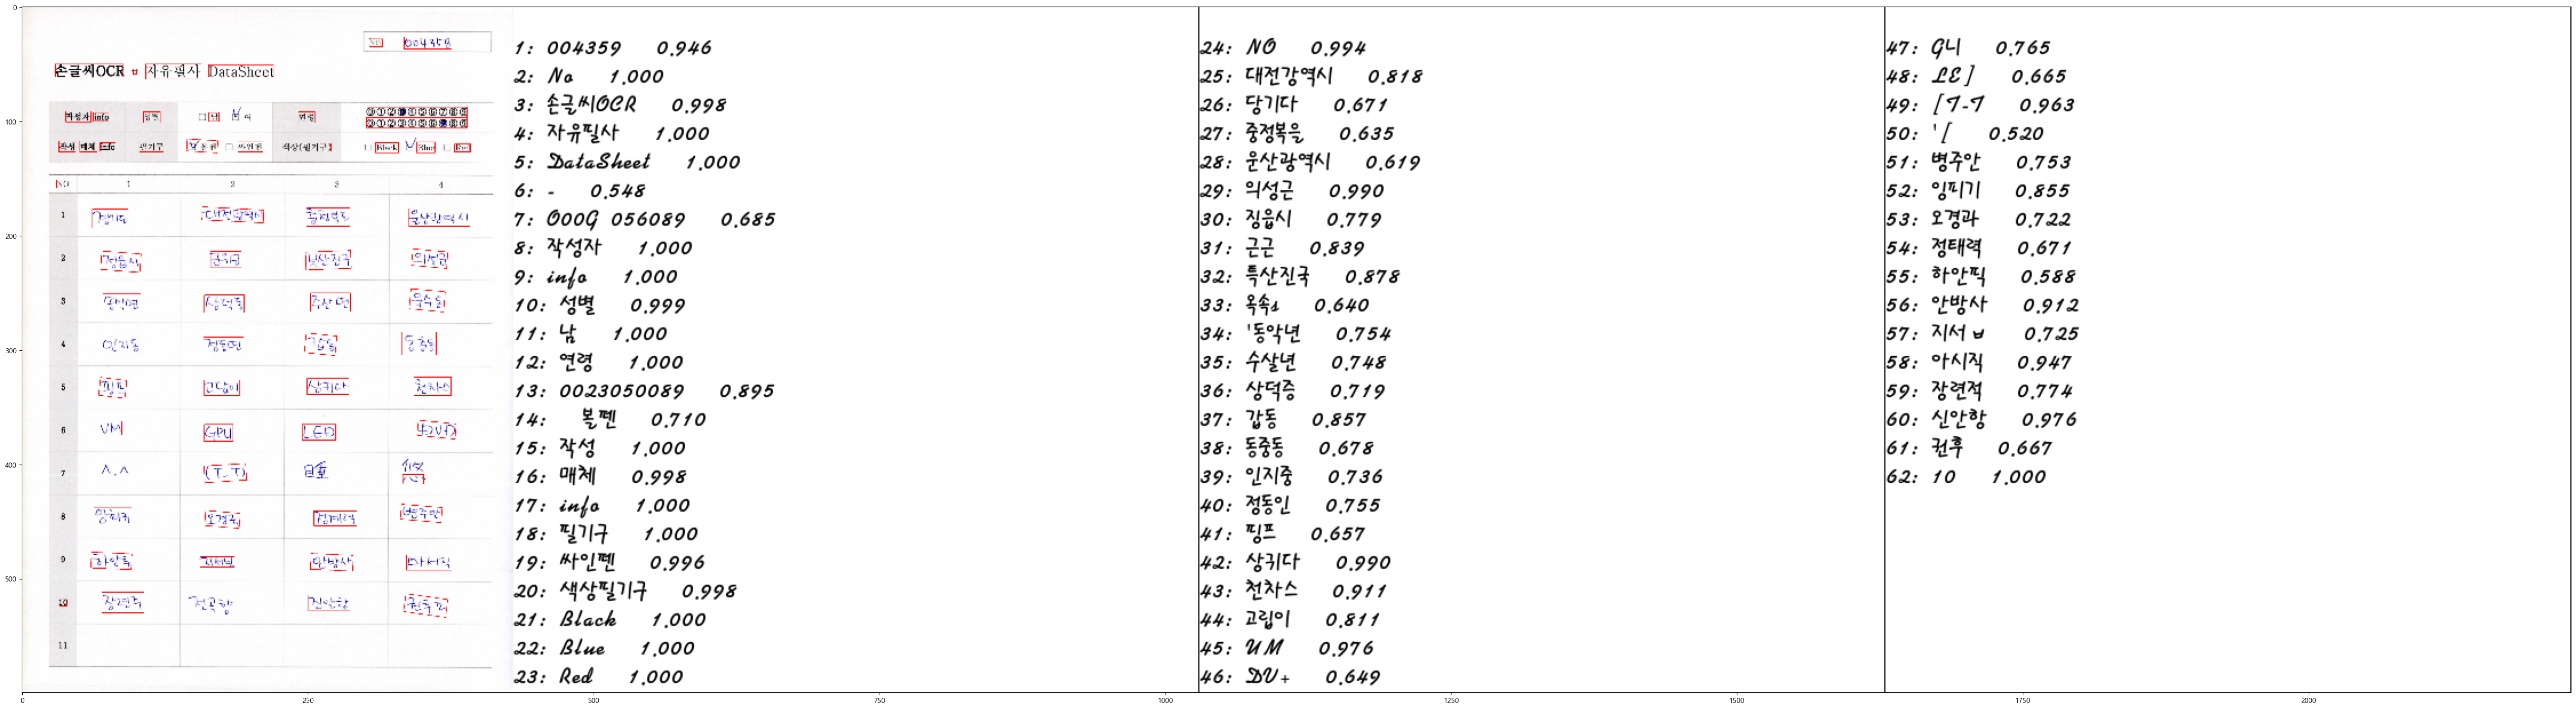

In [11]:
visualizeOCR(ocr_df.iloc[0])